In [1]:
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import pandas as pd
import anndata as ad
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

<h1> Niche calculations </h1>

load example data with cell type annotation:

In [2]:
adata = sq.datasets.seqfish()

Every niche method requires a spatial neighborhood graph, which is why `sq.gr.spatial_neighbors` needs to be run first.

In [3]:
sq.gr.spatial_neighbors(adata, coord_type="generic", percentile=99, delaunay=False, n_neighs=5)

Let's begin with the neighborhood profile clustering approach. Here we first build the neighborhood profile:

In [4]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="neighborhood")

Which is now stored in `.obsm`

In [5]:
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors', 'spatial_neighbors'
    obsm: 'X_umap', 'spatial', 'neighborhood_profile'
    obsp: 'spatial_connectivities', 'spatial_distances'

For further processing we turn the neighborhood profile into an `AnnData` object

In [5]:
adata_nhood = ad.AnnData(X=adata.obsm["neighborhood_profile"])

In [6]:
adata_nhood

AnnData object with n_obs × n_vars = 19416 × 22

In [8]:
adata_nhood.X

array([[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.6, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

Run PCA, nearest neighbors and Leiden clustering:

In [7]:
sc.pp.pca(adata_nhood)
sc.pp.neighbors(adata_nhood)
sc.tl.leiden(adata_nhood)

Move the result back into our original data.

In [8]:
adata.obs["neighbor_niche"] = adata_nhood.obs["leiden"]

Visualize the result by comparing it to the cell type annotation:

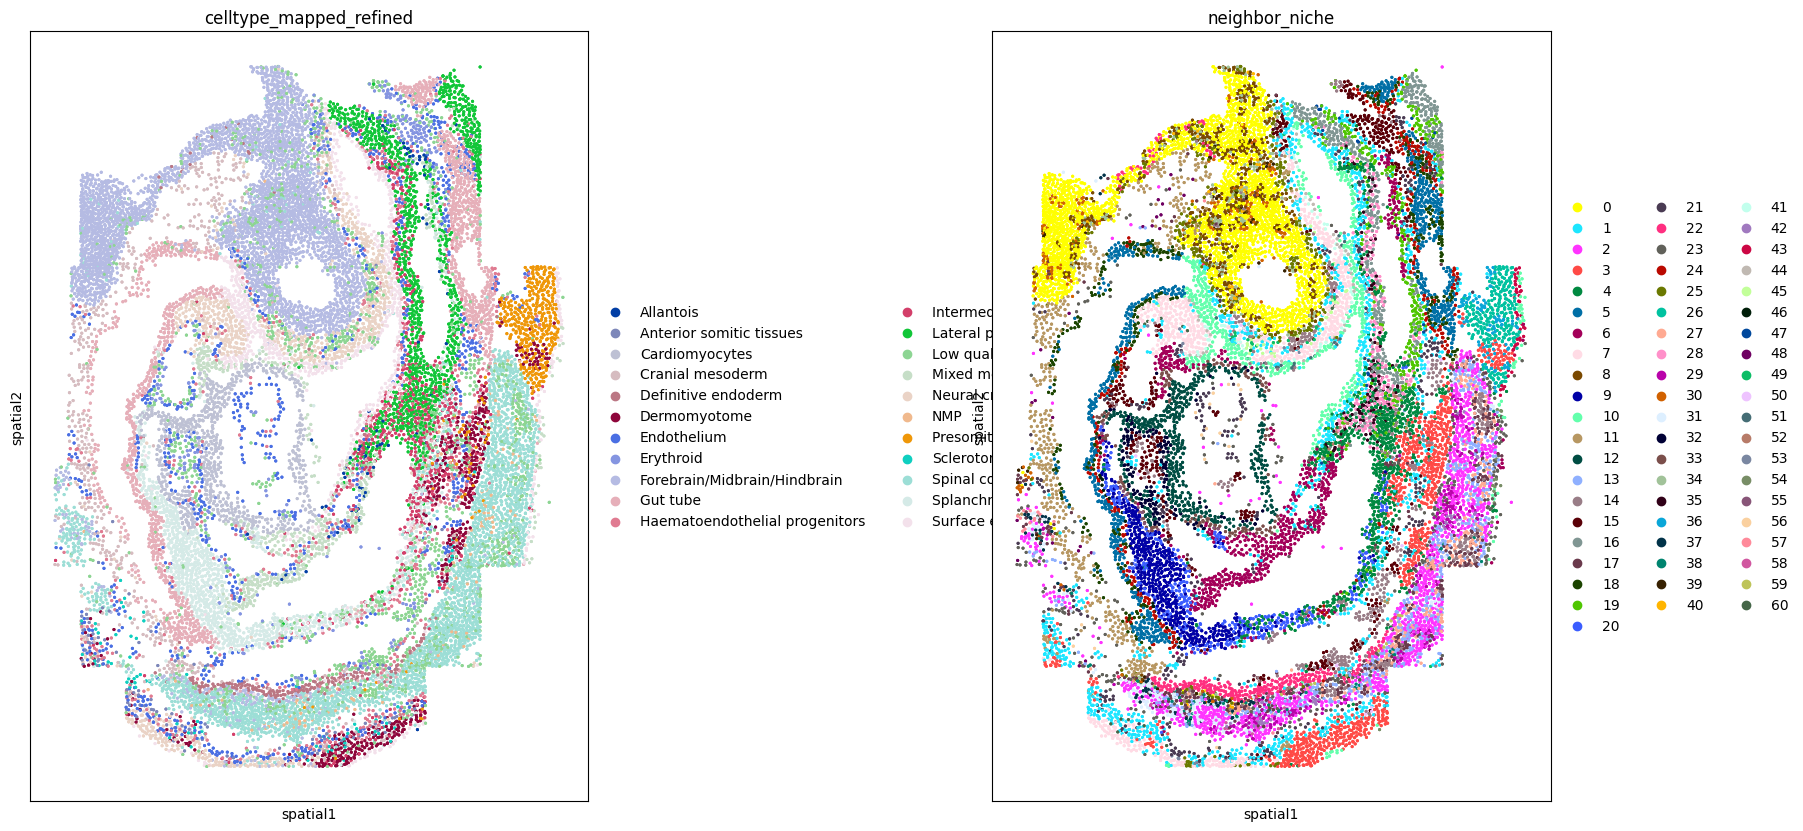

In [11]:
sq.pl.spatial_scatter(
    adata, color=["celltype_mapped_refined","neighbor_niche"], shape=None, figsize=(10, 10)
)

<h1> UTAG </h1>
Next we follow the UTAG approach, which involves the count matrix stored in adata.X.

In [9]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="utag")

The new count matrix is stored in a different layer.

In [10]:
adata.layers["utag"]

<19416x351 sparse matrix of type '<class 'numpy.float64'>'
	with 4411029 stored elements in Compressed Sparse Row format>

Proceed as before during the neighborhood approach.

In [11]:
sc.pp.pca(adata, layer="utag")
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, neighbors_key="neighbors")
adata.obs["utag_niche"] = adata.obs["leiden"]

Visualize the result:

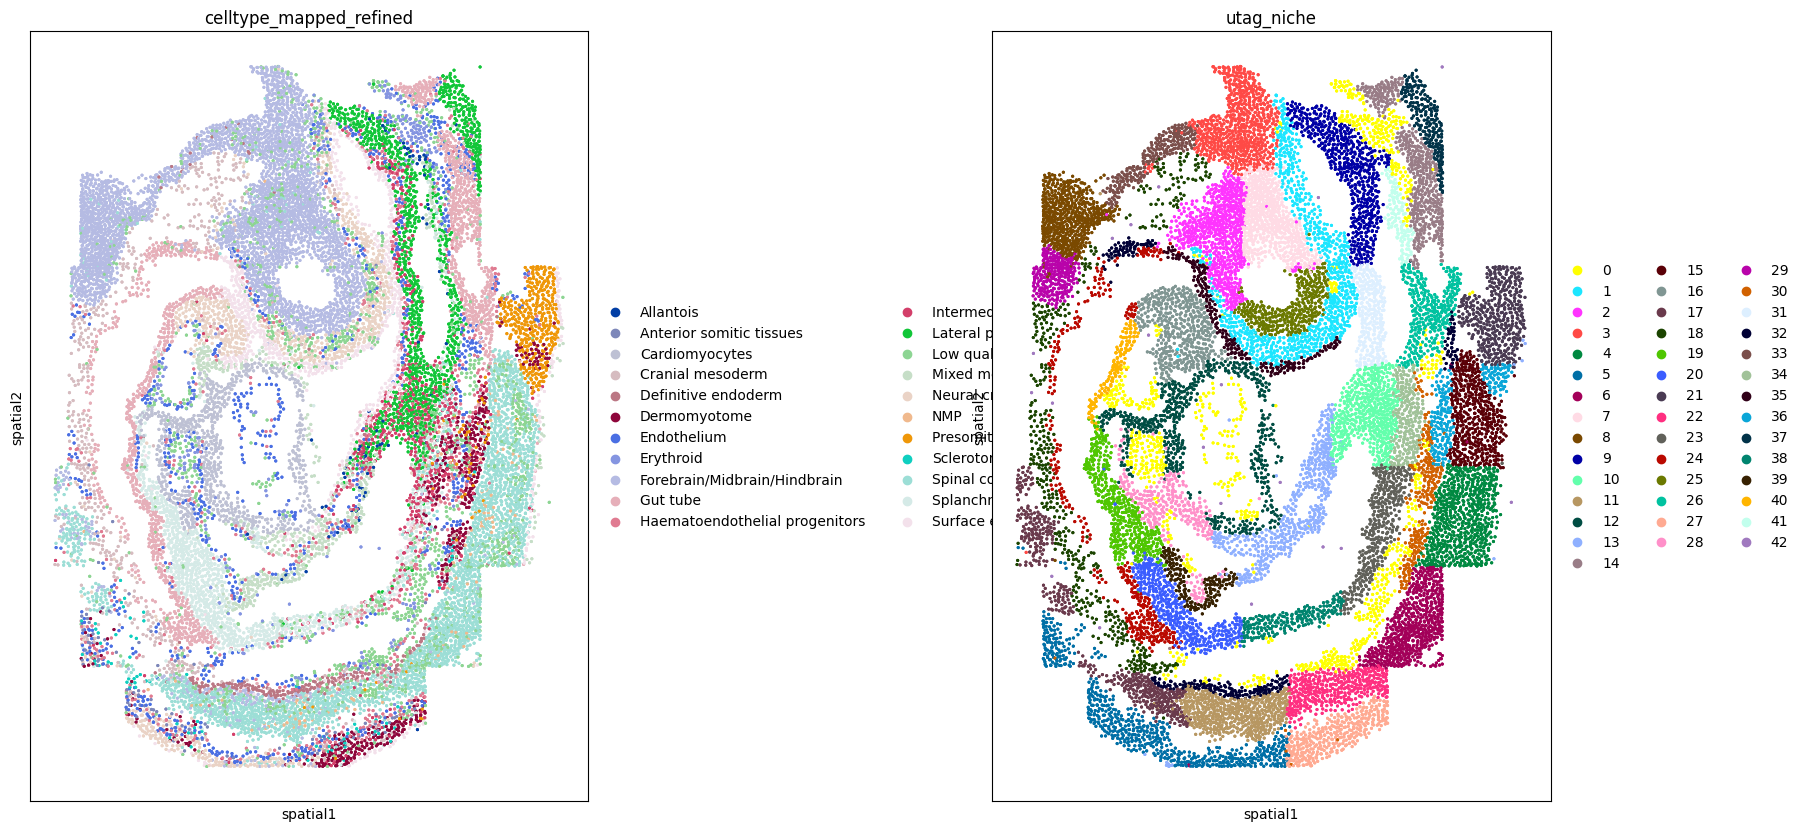

In [15]:
sq.pl.spatial_scatter(
    adata, color=["celltype_mapped_refined","utag_niche"], shape=None, figsize=(10, 10)
)

For comparison we also cluster our count data without including spatial information:

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, neighbors_key="neighbors")

Visual comparison of all clustering results:

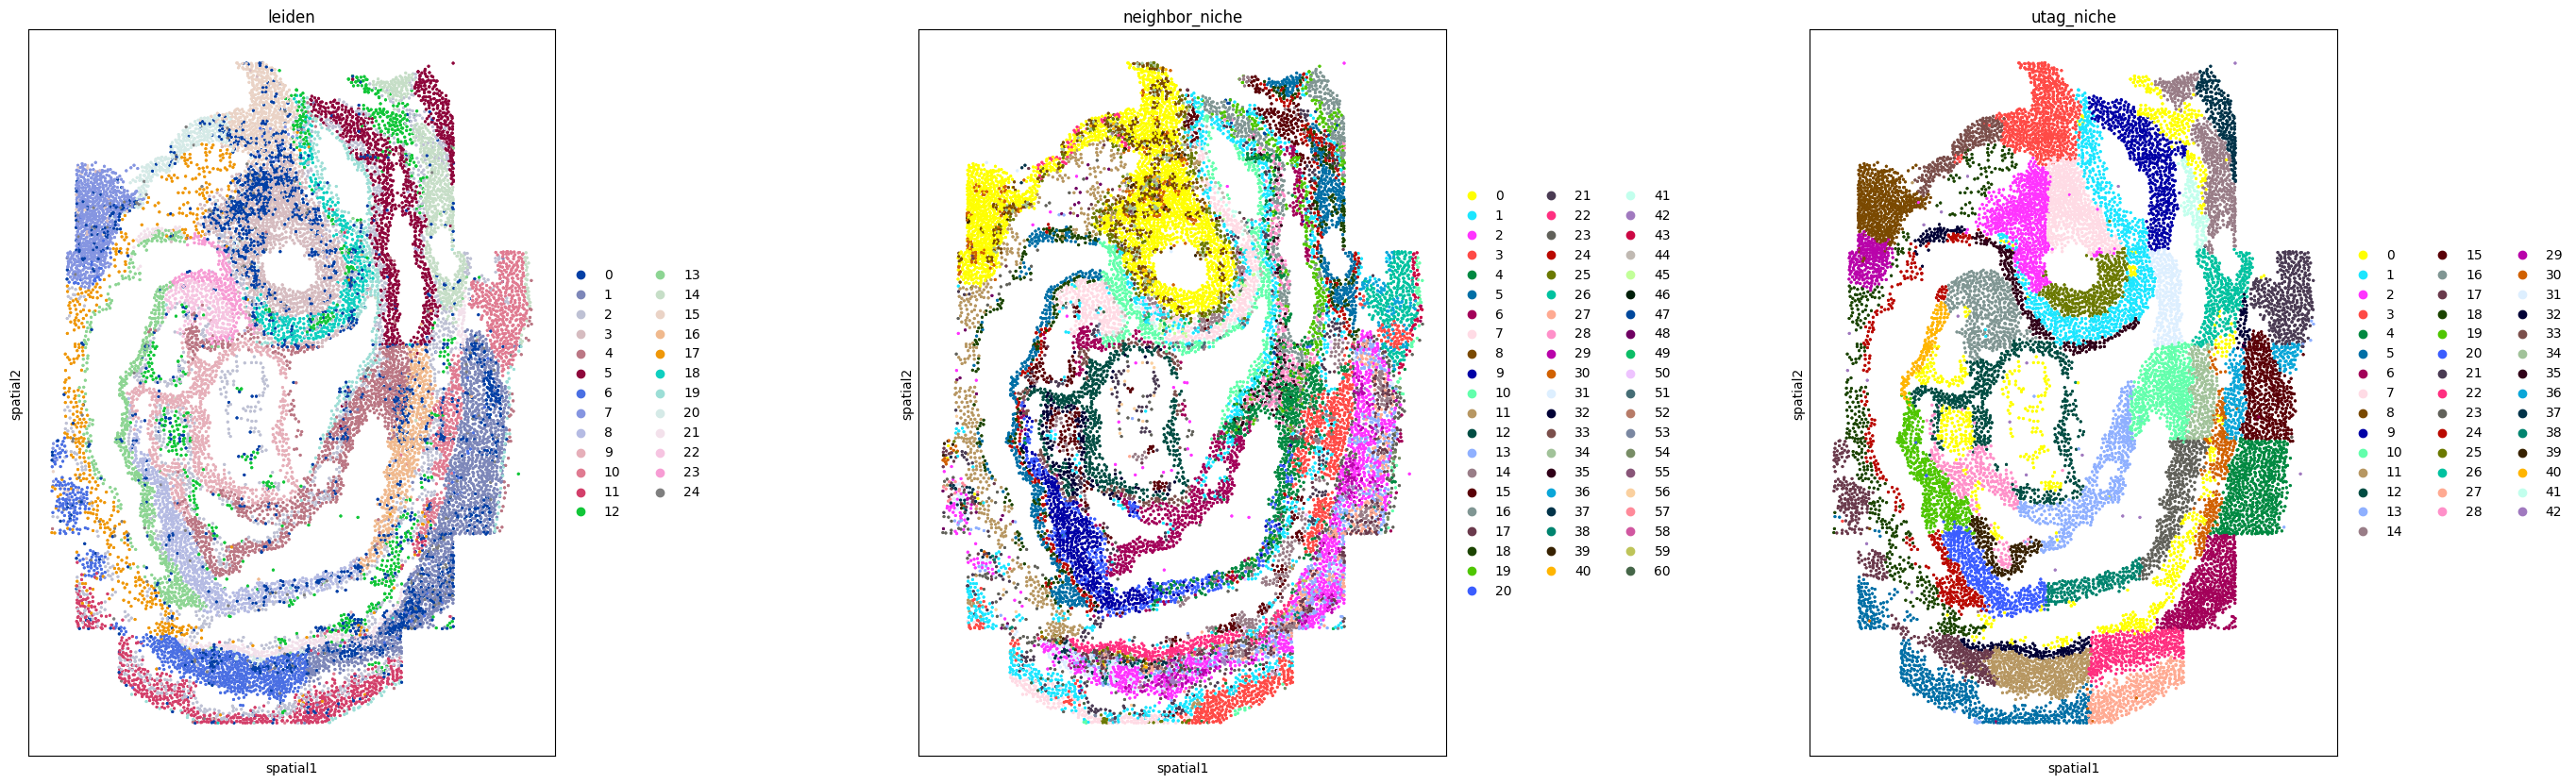

In [17]:
sq.pl.spatial_scatter(
    adata, color=["leiden", "neighbor_niche", "utag_niche",], shape=None, figsize=(10, 10)
)

Let's compare these results with some scores, to see how much they align with each other:

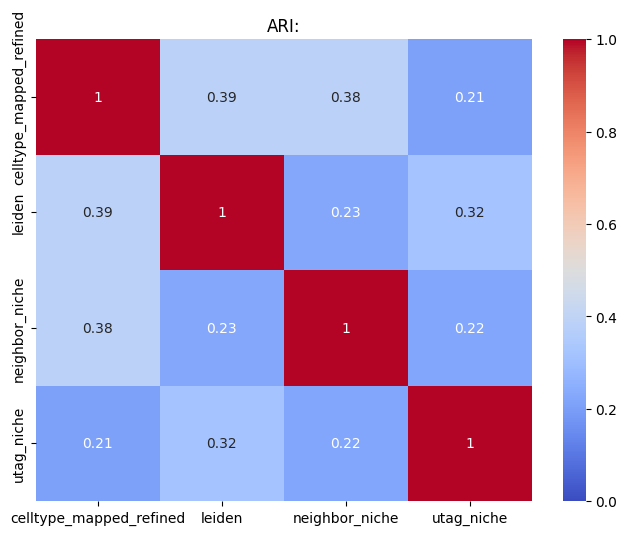

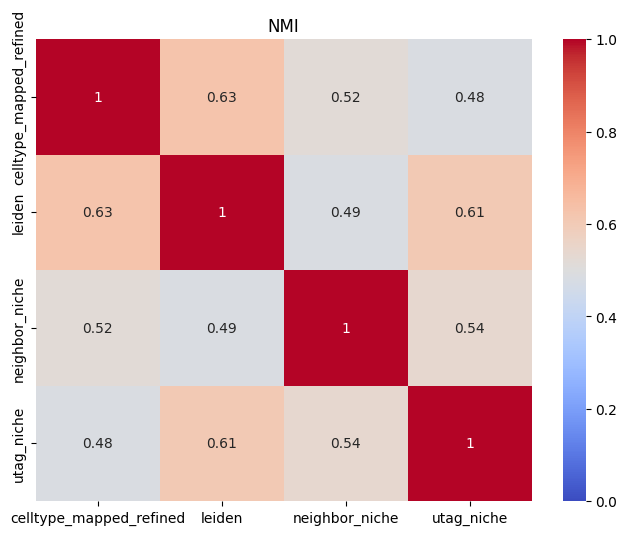

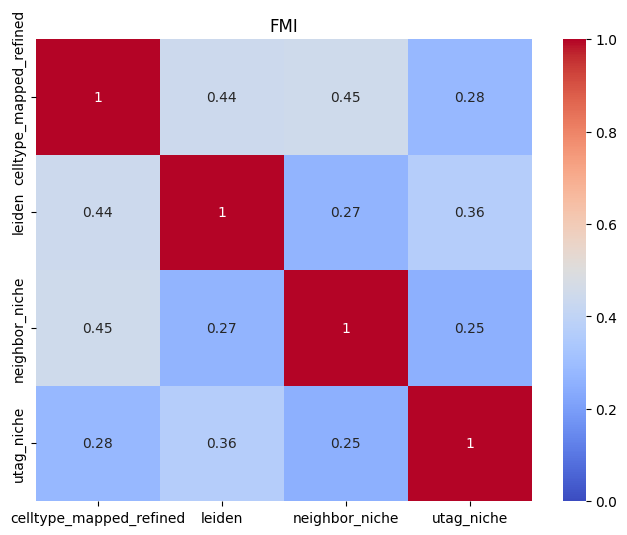

In [18]:
niche_definitions = ["celltype_mapped_refined", "leiden", "neighbor_niche", "utag_niche"]
result = pd.DataFrame(index=niche_definitions, columns=niche_definitions, data=None, dtype=float)
combinations = list(itertools.combinations_with_replacement(niche_definitions, 2))
scores = {"ARI:": adjusted_rand_score, "NMI": normalized_mutual_info_score, "FMI": fowlkes_mallows_score}
for score_name, score_func in scores.items():
    for pair in combinations:
        score = score_func(adata.obs[pair[0]], adata.obs[pair[1]])
        result.at[pair[0], pair[1]] = score
        result.at[pair[1], pair[0]] = score
    plt.figure(figsize=(8, 6))
    sns.heatmap(result, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(score_name)
    plt.show

For the Cellcharter approach, we can calculate the matrix which is later used for clustering. In their paper they used GMMs.

In [19]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="cellcharter", adj_subsets=[0,1,3])

(19416, 19416)
(19416, 19416)


The "Adj_n" after each var name refers to the n-neighbors adjacency matrix.

In [20]:
adata.obsm["cellcharter_niche"]

Abcc4_Adj_0  Acp5_Adj_0  Acvr1_Adj_0  Acvr2a_Adj_0  \
embryo1_Pos0_cell10_z2           0.0         5.0          4.0           4.0   
embryo1_Pos0_cell10_z5           1.0         0.0          0.0           2.0   
embryo1_Pos0_cell100_z2          0.0         6.0          0.0           0.0   
embryo1_Pos0_cell100_z5          0.0         1.0          2.0           2.0   
embryo1_Pos0_cell101_z2          0.0         6.0          0.0           0.0   
...                              ...         ...          ...           ...   
embryo1_Pos28_cell97_z2          4.0         7.0          1.0           4.0   
embryo1_Pos28_cell97_z5          1.0         4.0          2.0           0.0   
embryo1_Pos28_cell98_z2          2.0         2.0          0.0           2.0   
embryo1_Pos28_cell98_z5          0.0         1.0          0.0           0.0   
embryo1_Pos28_cell99_z5          0.0         0.0          0.0           2.0   

                         Adora2b_Adj_0  Afp_Adj_0  Ahnak_Adj_0  Akr1c19_Adj_0  \
embryo1_Pos0_cell10_z2             0.0        1.0          4.0            3.0   
embryo1_Pos0_cell10_z5             0.0        1.0          2.0            7.0   
embryo1_Pos0_cell100_z2            0.0        0.0          1.0            0.0   
embryo1_Pos0_cell100_z5            0.0        0.0          0.0           13.0   
embryo1_Pos0_cell101_z2            0.0        0.0          0.0            2.0   
...                                ...        ...          ...            ...   
embryo1_Pos28_cell97_z2            2.0        2.0          5.0           12.0   
embryo1_Pos28_cell97_z5            0.0        1.0          0.0            0.0   
embryo1_Pos28_cell98_z2            2.0        1.0          3.0            8.0   
embryo1_Pos28_cell98_z5            0.0        1.0          0.0            1.0   
embryo1_Pos28_cell99_z5            1.0        0.0          1.0            1.0   

                         Alas2_Adj_0  Aldh1a2_Adj_0  ...  Wnt2b_Adj_3  \
embryo1_Pos0_cell10_z2           2.0            6.0  ...          0.0   
embryo1_Pos0_cell10_z5           0.0            3.0  ...          0.0   
embryo1_Pos0_cell100_z2         13.0            0.0  ...          0.0   
embryo1_Pos0_cell100_z5          4.0            3.0  ...          0.0   
embryo1_Pos0_cell101_z2         11.0            0.0  ...          0.0   
...                              ...            ...  ...          ...   
embryo1_Pos28_cell97_z2          0.0            3.0  ...          0.0   
embryo1_Pos28_cell97_z5         13.0           29.0  ...          0.0   
embryo1_Pos28_cell98_z2          1.0            5.0  ...          0.0   
embryo1_Pos28_cell98_z5          4.0           27.0  ...          0.0   
embryo1_Pos28_cell99_z5          0.0            7.0  ...          0.0   

                         Wnt3_Adj_3  Wnt3a_Adj_3  Wnt5a_Adj_3  Wnt5b_Adj_3  \
embryo1_Pos0_cell10_z2          0.0          0.0          0.0          0.0   
embryo1_Pos0_cell10_z5          0.0          0.0          0.0          0.0   
embryo1_Pos0_cell100_z2         0.0          0.0          0.0          0.0   
embryo1_Pos0_cell100_z5         0.0          0.0          0.0          0.0   
embryo1_Pos0_cell101_z2         0.0          0.0          0.0          0.0   
...                             ...          ...          ...          ...   
embryo1_Pos28_cell97_z2         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell97_z5         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell98_z2         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell98_z5         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell99_z5         0.0          0.0          0.0          0.0   

                         Wnt8a_Adj_3  Xist_Adj_3  Zfp444_Adj_3  Zfp57_Adj_3  \
embryo1_Pos0_cell10_z2           0.0         0.0           0.0          0.0   
embryo1_Pos0_cell10_z5           0.0         0.0           0.0          0.0   
embryo1_Pos0_cell100_z2          0.0         0.0    

In [21]:
adata.obs

Area         celltype_mapped_refined neighbor_niche  \
embryo1_Pos0_cell10_z2   10400                     Low quality             19   
embryo1_Pos0_cell10_z5    2256          Lateral plate mesoderm             28   
embryo1_Pos0_cell100_z2   8144                       Erythroid             15   
embryo1_Pos0_cell100_z5   6592          Lateral plate mesoderm              4   
embryo1_Pos0_cell101_z2   8560                       Erythroid             15   
...                        ...                             ...            ...   
embryo1_Pos28_cell97_z2   7552                     Spinal cord             23   
embryo1_Pos28_cell97_z5   3408                     Endothelium              1   
embryo1_Pos28_cell98_z2  12704                     Spinal cord             31   
embryo1_Pos28_cell98_z5  11376  Haematoendothelial progenitors              1   
embryo1_Pos28_cell99_z5   5392                     Spinal cord             11   

                        leiden utag_niche  
embryo1_Pos0_cell10_z2      12          9  
embryo1_Pos0_cell10_z5       5          9  
embryo1_Pos0_cell100_z2     12          0  
embryo1_Pos0_cell100_z5      5          9  
embryo1_Pos0_cell101_z2     12          0  
...                        ...        ...  
embryo1_Pos28_cell97_z2      6         17  
embryo1_Pos28_cell97_z5      2          5  
embryo1_Pos28_cell98_z2      6         17  
embryo1_Pos28_cell98_z5     11          5  
embryo1_Pos28_cell99_z5      6         17  

[19416 rows x 5 columns]

In [13]:
def get_subset_indices(df, column):
    return df.groupby(column).apply(lambda x: set(x.index))

In [14]:
subsets_A = get_subset_indices(adata.obs, 'leiden')
subsets_B = get_subset_indices(adata.obs, 'utag_niche')
subsets_C = get_subset_indices(adata.obs, 'neighbor_niche')

In [15]:
list_of_sets = [subsets_A, subsets_B, subsets_C]

In [16]:
def find_best_match(subset, other_subsets, exclude=[]):
    best_match = None
    max_overlap = 0
    for other_subset, indices in other_subsets.items():
        if other_subset in exclude:
            continue  # Skip excluded matches
        overlap = len(subset & indices) / len(subset | indices) # jaccard index
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = other_subset
    return best_match, max_overlap


In [28]:
union_of_matches = list_of_sets[0]
avg_jaccard = np.zeros(len(union_of_matches))
for set_of_sets in range(len(list_of_sets)-1):
    current_matches = {}
    used_matches = set()
    matches_A_B = {subset: find_best_match(indices, list_of_sets[set_of_sets+1]) for subset, indices in union_of_matches.items()}
    ranked_matches = sorted(matches_A_B.items(), key=lambda x: x[1][1], reverse=True)
    for subset_A, (match, jaccard_index) in ranked_matches:
        if match not in used_matches:
            current_matches[subset_A] = (match, jaccard_index)
            used_matches.add(match)
        else:
            new_match, new_jaccard = find_best_match(union_of_matches[subset_A], list_of_sets[set_of_sets+1], exclude=used_matches)
            if new_match:
                current_matches[subset_A] = (new_match, new_jaccard)
                used_matches.add(new_match)

    jaccard = np.asarray([jaccard_index for _, (_, jaccard_index) in current_matches.items()])
    avg_jaccard = (avg_jaccard + jaccard) / (set_of_sets+1)

    union_of_matches = ({subset_A: union_of_matches[subset_A] | list_of_sets[set_of_sets+1][match] for subset_A, (match, _) in current_matches.items()})
    intersection_of_matches = {subset_A: union_of_matches[subset_A] & list_of_sets[set_of_sets+1][match] for subset_A, (match, _) in current_matches.items()}
keys = list(intersection_of_matches.keys())
new_dict = dict(zip(keys, avg_jaccard))

In [25]:
union_of_matches

{'9': {'embryo1_Pos10_cell248_z5',
  'embryo1_Pos10_cell262_z5',
  'embryo1_Pos10_cell276_z5',
  'embryo1_Pos10_cell291_z5',
  'embryo1_Pos10_cell292_z2',
  'embryo1_Pos10_cell296_z2',
  'embryo1_Pos10_cell317_z2',
  'embryo1_Pos10_cell322_z2',
  'embryo1_Pos10_cell353_z2',
  'embryo1_Pos10_cell356_z2',
  'embryo1_Pos10_cell362_z2',
  'embryo1_Pos10_cell375_z2',
  'embryo1_Pos10_cell385_z2',
  'embryo1_Pos10_cell400_z2',
  'embryo1_Pos10_cell51_z5',
  'embryo1_Pos10_cell55_z2',
  'embryo1_Pos10_cell77_z2',
  'embryo1_Pos12_cell102_z5',
  'embryo1_Pos12_cell114_z5',
  'embryo1_Pos12_cell120_z5',
  'embryo1_Pos12_cell121_z5',
  'embryo1_Pos12_cell122_z5',
  'embryo1_Pos12_cell125_z5',
  'embryo1_Pos12_cell127_z5',
  'embryo1_Pos12_cell129_z5',
  'embryo1_Pos12_cell131_z5',
  'embryo1_Pos12_cell132_z5',
  'embryo1_Pos12_cell134_z5',
  'embryo1_Pos12_cell136_z5',
  'embryo1_Pos12_cell138_z5',
  'embryo1_Pos12_cell139_z5',
  'embryo1_Pos12_cell140_z5',
  'embryo1_Pos12_cell141_z5',
  'embry

In [22]:
def filter_dict(original_dict):
    new_dict = {}
    processed_elements = set()

    for key, values in original_dict.items():
        unique_values = values - processed_elements  # Remove already processed elements
        for value in unique_values:
            new_dict[value] = key  # Add the value as the new key, with the original key as its value
        processed_elements.update(unique_values)  # Mark these values as processed

    return new_dict

In [26]:
a = filter_dict(intersection_of_matches)

In [27]:
a

{'embryo1_Pos13_cell35_z2': '9',
 'embryo1_Pos13_cell196_z2': '9',
 'embryo1_Pos14_cell82_z2': '9',
 'embryo1_Pos14_cell32_z5': '9',
 'embryo1_Pos20_cell394_z2': '9',
 'embryo1_Pos14_cell61_z2': '9',
 'embryo1_Pos13_cell42_z5': '9',
 'embryo1_Pos14_cell88_z2': '9',
 'embryo1_Pos13_cell3_z5': '9',
 'embryo1_Pos20_cell82_z2': '9',
 'embryo1_Pos12_cell227_z2': '9',
 'embryo1_Pos13_cell21_z2': '9',
 'embryo1_Pos13_cell249_z2': '9',
 'embryo1_Pos14_cell117_z2': '9',
 'embryo1_Pos19_cell204_z2': '9',
 'embryo1_Pos13_cell214_z5': '9',
 'embryo1_Pos13_cell323_z2': '9',
 'embryo1_Pos14_cell37_z5': '9',
 'embryo1_Pos13_cell122_z5': '9',
 'embryo1_Pos20_cell148_z2': '9',
 'embryo1_Pos14_cell83_z2': '9',
 'embryo1_Pos13_cell80_z5': '9',
 'embryo1_Pos12_cell254_z2': '9',
 'embryo1_Pos20_cell281_z2': '9',
 'embryo1_Pos20_cell277_z5': '9',
 'embryo1_Pos20_cell247_z5': '9',
 'embryo1_Pos20_cell274_z5': '9',
 'embryo1_Pos14_cell62_z2': '9',
 'embryo1_Pos13_cell137_z5': '9',
 'embryo1_Pos20_cell261_z2':

In [74]:
sorted_categories = sorted(new_dict.keys(), key=lambda x: new_dict[x], reverse=True)
sorted_categories

['9',
 '17',
 '8',
 '21',
 '14',
 '15',
 '10',
 '7',
 '12',
 '13',
 '16',
 '18',
 '20',
 '22',
 '23',
 '6',
 '3',
 '5',
 '11',
 '1',
 '4',
 '2',
 '0',
 '19',
 '24']

In [134]:
filtered_B = union_of_matches.copy()

In [136]:
values = filtered_B.values()
values = list(values)

In [137]:
for i, key_1 in enumerate(sorted_categories):
    for j in range(i, len(sorted_categories)-1):
        key_2 = sorted_categories[j]
        duplicates = filtered_B[key_1] & filtered_B[key_2]
        print(len(duplicates))
        #if len(duplicates) > 0:
        #    filtered_B[key_2] -= duplicates

870
0
17
0
1
0
0
0
29
1
1
0
0
13
6
4
0
0
0
4
69
49
5
8
765
0
12
2
8
1
16
17
76
4
17
23
1
4
34
16
0
49
15
2
91
66
0
948
0
2
0
0
0
16
17
75
0
0
2
1
0
0
1
1
0
82
19
32
1
475
66
17
2
1
13
81
1
0
327
0
2
45
3
0
3
23
0
23
23
1
1219
1
30
1
20
847
1
0
1
35
57
0
1
10
2
0
2
81
36
22
2853
0
2516
13
0
0
16
229
0
0
28
2523
0
0
6
1
9
2574
0
811
0
2
0
23
1
1
1
25
1
0
0
307
14
7
22
6
25
2735
1
0
0
7
196
0
0
41
2511
0
0
5
1
2
2533
0
1252
1
26
103
11
8
2
8
7
27
17
9
18
1045
123
12
1218
0
2
7
41
41
1
1
1
0
1
6
23
42
1
1207
3
0
1
0
2
1
110
116
26
305
74
134
64
1277
2
675
72
1
62
1
159
0
13
140
102
120
650
0
1
49
191
0
3
15
0
19
228
0
967
143
1
7
0
159
0
103
45
36
95
684
0
63
69
3
8
85
19
60
553
1847
27
1
12
1075
4
9
185
4
3039
0
2
5
1
10
2712
51
1356
0
3
119
118
21
640
1535
29
4
243
81
28
2242
23
9
171
28
1648
128
103
112
2217
129
116
4394
52
1277


In [29]:
index_to_category = {}
for category, indices in intersection_of_matches.items():
    for index in indices:
        index_to_category[index] = category

In [30]:
adata.obs['consensus'] = adata.obs.index.map(index_to_category).fillna('None')

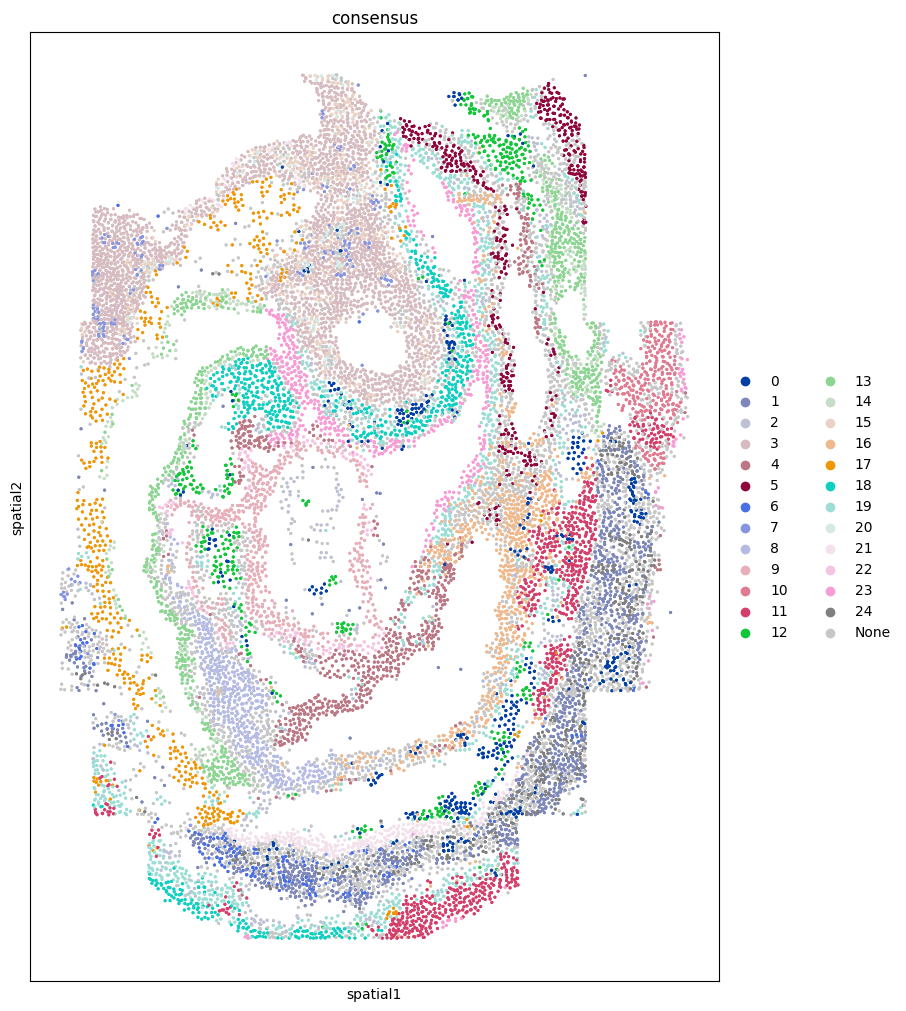

In [32]:
sq.pl.spatial_scatter(
    adata, color=["consensus"], shape=None, figsize=(10, 10)
)

In [58]:
[(i+j)/2 for i,j in zip([1,2,3],[4,5,6])]

[2.5, 3.5, 4.5]

In [38]:
matches_A_B

{'0': ('2', 0.13278495887191538),
 '1': ('4', 0.3198426082068578),
 '2': ('0', 0.14891655140617796),
 '3': ('7', 0.29993364299933645),
 '4': ('10', 0.3053763440860215),
 '5': ('9', 0.33178654292343385),
 '6': ('11', 0.454049135577798),
 '7': ('8', 0.5586652314316469),
 '8': ('20', 0.4710059171597633),
 '9': ('12', 0.5902777777777778),
 '10': ('21', 0.4777777777777778),
 '11': ('5', 0.4129763130792997),
 '12': ('0', 0.37397034596375617),
 '13': ('24', 0.39920948616600793),
 '14': ('14', 0.563858695652174),
 '15': ('3', 0.6638141809290954),
 '16': ('23', 0.45007451564828616),
 '17': ('18', 0.5682888540031397),
 '18': ('1', 0.4683684794672586),
 '19': ('9', 0.0824295010845987),
 '20': ('33', 0.6062992125984252),
 '21': ('32', 0.4818941504178273),
 '22': ('16', 0.4517374517374517),
 '23': ('35', 0.26525198938992045),
 '24': ('6', 0.05328376703841388)}

In [42]:
union_of_matches = {subset_A: subsets_A[subset_A] | subsets_B[match] for subset_A, (match, _) in matches_A_B.items()}

In [46]:
union_of_matches

{'0': {'embryo1_Pos4_cell401_z2',
  'embryo1_Pos16_cell281_z5',
  'embryo1_Pos4_cell134_z2',
  'embryo1_Pos4_cell302_z2',
  'embryo1_Pos11_cell73_z2',
  'embryo1_Pos15_cell265_z5',
  'embryo1_Pos4_cell347_z2',
  'embryo1_Pos18_cell218_z5',
  'embryo1_Pos27_cell436_z5',
  'embryo1_Pos25_cell280_z2',
  'embryo1_Pos4_cell167_z5',
  'embryo1_Pos4_cell300_z5',
  'embryo1_Pos25_cell443_z5',
  'embryo1_Pos9_cell368_z2',
  'embryo1_Pos26_cell122_z2',
  'embryo1_Pos25_cell86_z5',
  'embryo1_Pos15_cell140_z5',
  'embryo1_Pos3_cell372_z2',
  'embryo1_Pos25_cell171_z5',
  'embryo1_Pos4_cell232_z2',
  'embryo1_Pos25_cell236_z5',
  'embryo1_Pos27_cell14_z2',
  'embryo1_Pos4_cell430_z2',
  'embryo1_Pos4_cell371_z5',
  'embryo1_Pos4_cell107_z5',
  'embryo1_Pos4_cell167_z2',
  'embryo1_Pos15_cell202_z2',
  'embryo1_Pos5_cell139_z5',
  'embryo1_Pos17_cell99_z2',
  'embryo1_Pos4_cell263_z5',
  'embryo1_Pos8_cell49_z2',
  'embryo1_Pos4_cell323_z5',
  'embryo1_Pos4_cell364_z5',
  'embryo1_Pos24_cell141_z5'

In [47]:
matches_A_B_to_C = {subset: find_best_match(indices, subsets_C) for subset, indices in union_of_matches.items()}

In [48]:
matches_A_B_to_C

{'0': ('0', 0.1515703231679563),
 '1': ('2', 0.26538804638715435),
 '2': ('15', 0.19440685611186287),
 '3': ('0', 0.32082922013820336),
 '4': ('6', 0.2609223300970874),
 '5': ('16', 0.2853982300884956),
 '6': ('2', 0.16783974011911207),
 '7': ('0', 0.25630712979890313),
 '8': ('9', 0.5031645569620253),
 '9': ('12', 0.6011494252873564),
 '10': ('26', 0.34155363748458695),
 '11': ('3', 0.19543973941368079),
 '12': ('15', 0.3522364217252396),
 '13': ('5', 0.31773399014778325),
 '14': ('5', 0.2977850697292863),
 '15': ('0', 0.16543988783736419),
 '16': ('4', 0.25849212924606463),
 '17': ('11', 0.526797385620915),
 '18': ('7', 0.23022709475332812),
 '19': ('10', 0.1534847298355521),
 '20': ('22', 0.0876923076923077),
 '21': ('22', 0.4421052631578947),
 '22': ('7', 0.22854188210961737),
 '23': ('10', 0.3567251461988304),
 '24': ('2', 0.15551425030978935)}

In [49]:
union_of_matches_new = {subset_A: union_of_matches[subset_A] | subsets_C[match] for subset_A, (match, _) in matches_A_B_to_C.items()}

In [50]:
union_of_matches_new

{'0': {'embryo1_Pos4_cell134_z2',
  'embryo1_Pos2_cell75_z2',
  'embryo1_Pos3_cell124_z5',
  'embryo1_Pos3_cell174_z5',
  'embryo1_Pos4_cell302_z2',
  'embryo1_Pos11_cell73_z2',
  'embryo1_Pos11_cell129_z2',
  'embryo1_Pos2_cell237_z2',
  'embryo1_Pos1_cell29_z5',
  'embryo1_Pos3_cell172_z5',
  'embryo1_Pos5_cell93_z5',
  'embryo1_Pos25_cell280_z2',
  'embryo1_Pos4_cell167_z5',
  'embryo1_Pos4_cell300_z5',
  'embryo1_Pos11_cell200_z2',
  'embryo1_Pos11_cell75_z2',
  'embryo1_Pos15_cell140_z5',
  'embryo1_Pos9_cell222_z5',
  'embryo1_Pos25_cell236_z5',
  'embryo1_Pos27_cell14_z2',
  'embryo1_Pos4_cell107_z5',
  'embryo1_Pos3_cell432_z2',
  'embryo1_Pos4_cell167_z2',
  'embryo1_Pos17_cell99_z2',
  'embryo1_Pos4_cell263_z5',
  'embryo1_Pos3_cell69_z5',
  'embryo1_Pos8_cell49_z2',
  'embryo1_Pos3_cell392_z5',
  'embryo1_Pos4_cell364_z5',
  'embryo1_Pos3_cell28_z2',
  'embryo1_Pos1_cell176_z5',
  'embryo1_Pos2_cell82_z2',
  'embryo1_Pos3_cell196_z2',
  'embryo1_Pos5_cell354_z5',
  'embryo1_